In [1]:
# ******ignore warnings
import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
from scipy import stats
import os


# ******files/data
from pydataset import data
import env
# import acquire
# import prepare


# ******visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# ******sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 01. Data Acquisition
### Acquiring telco data from Codeup DB

In [2]:
# function to connect to Codeup DB using credentials from env.py file 

def connect_to_db(db, user = env.user, host = env.host, password = env.password):
    '''
    This function takes in a database and login credentials to establish a connection to the
    Codeup database, returning a string that can be used to query the database in the read_sql function
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

### Reading querying the database (that we established a connection to in previous step), returning the database and a Dataframe

In [3]:
# variable to store query for read_sql
sql_query = '''select * from customers 
                join contract_types using (contract_type_id) 
                join internet_service_types using (internet_service_type_id) 
                join payment_types using (payment_type_id)'''

# variable to store returned database 
raw_data = pd.read_sql(sql_query ,connect_to_db('telco_churn'))
raw_data.head(2)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)


### Caching Database as .csv file

In [4]:
# writing newly acquired Dataframe to .csv file
raw_data.to_csv('telco_data.csv')

# Function for acquire.py file

In [5]:
# these two functions will be inputs for the main acquire_telco_data() function

def get_connection(db, user = env.user, host = env.host, password = env.password):
    '''
    This function takes in login credentials from env file as an arguments and will be used to establish a 
    connection to Codeup Database by returning a connection URL.
    
    This will be the first of two input functions for our final acquire_telco_data function.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

    
def new_telco_data():
    '''
    This function will store the sequel query that will be used, along with the get_connection function, 
    to read the telco data into a DataFrame, storing that DataFrame
    
    This will be the second of two input functions for our final acquire_telco_data function.
    ''' 
    
#   creating the variable that will hold the code used to query the Codeup database    
    sql_query = '''select * from customers 
                    join contract_types using (contract_type_id) 
                    join internet_service_types using (internet_service_type_id) 
                    join payment_types using (payment_type_id)'''
    
#   using the get_connection() function and sql_query to read in DataFrame from Codeup database
    df = pd.read_sql(sql_query, get_connection('telco_churn'))
    
    return df
    


In [6]:
def acquire_telco_data():
    '''
    This is the main acquire_telco_data function that checks to see if a local csv for telco data exists.
        If it does it will write the csv data into a DataFrame
            (else)
        If the telco data csv file does not exist locally, it will use the input function new_telco_data to 
        query the Codeup database and return the query as DataFrame .
            It will then cache the DataFrame and create local csv file. 
    '''
    if os.path.isfile('telco_data'):
#   if csv file already exists in local directory, this code will run

        df = pd.read_csv('telco_data', index_col = 0)
#       this line of code reads the telco csv file into a Database

    else:
#   if csv file does not exist in local directory, this code will run instead

        df = new_telco_data()
#       this line of code reads telco database into a DataFrame using the input function new_telco_data

        df.to_csv('telco_data.csv')
#       this line of code caches the telco data, creating a local csv file

    return df


In [7]:
# running final acquire_telco_data function and then previewing

raw_data = acquire_telco_data()
raw_data.head(2)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)


***

# 02 Data Preparation

In [8]:
# let's take a look at our raw_data df

print(f'Rows: {raw_data.shape[0]} \nColumns: {raw_data.shape[1]}')

Rows: 7043 
Columns: 24


In [9]:
# dtypes of each column

raw_data.dtypes.value_counts()

object     18
int64       5
float64     1
dtype: int64

In [10]:
# crosstabs

contract_crosstab = pd.crosstab(raw_data.contract_type, raw_data.contract_type_id)
print(contract_crosstab)
print('------------------------------------------------------------------')
internet_crosstab = pd.crosstab(raw_data.internet_service_type, raw_data.internet_service_type_id)
print(internet_crosstab)
print('------------------------------------------------------------------')
payment_crosstab = pd.crosstab(raw_data.payment_type, raw_data.payment_type_id)
print(payment_crosstab)

contract_type_id     1     2     3
contract_type                     
Month-to-month    3875     0     0
One year             0  1473     0
Two year             0     0  1695
------------------------------------------------------------------
internet_service_type_id     1     2     3
internet_service_type                     
DSL                       2421     0     0
Fiber optic                  0  3096     0
None                         0     0  1526
------------------------------------------------------------------
payment_type_id               1     2     3     4
payment_type                                     
Bank transfer (automatic)     0     0  1544     0
Credit card (automatic)       0     0     0  1522
Electronic check           2365     0     0     0
Mailed check                  0  1612     0     0


## Contract
- 1: mtm
- 2: 1yr
- 3; 2yr
## Internet
- 1: dsl
- 2: fiber
- 3: none

## Payment
- 1: echeck
- 2: mail
- 3: bankxfer_auto
- 4: credit_auto

In [11]:
import prepare # this is the file with all of the functions used to clean and split the raw Telco data

train, validate, test = prepare.prep_telco_data(raw_data)

In [12]:
print(f'Train: {train.shape}') 
print(f'Validate: {validate.shape}') 
print(f'Test: {test.shape}') 

Train: (3937, 31)
Validate: (1688, 31)
Test: (1407, 31)


In [13]:
train.dtypes

gender                                     int64
senior_citizen                             int64
partner                                    int64
dependents                                 int64
tenure                                     int64
phone_service                              int64
paperless_billing                          int64
monthly_charges                          float64
total_charges                            float64
churn                                      int64
multiple_lines_no_phone_service            uint8
multiple_lines_yes                         uint8
online_security_no_internet_service        uint8
online_security_yes                        uint8
online_backup_no_internet_service          uint8
online_backup_yes                          uint8
device_protection_no_internet_service      uint8
device_protection_yes                      uint8
tech_support_no_internet_service           uint8
tech_support_yes                           uint8
streaming_tv_no_inte

In [14]:
# grouping columns by values
# making sure our variables were correctly encoded

bin_cols = []
num_cols = []
contin_cols = []

# this for loop will print a report with each columns unique values, for columns with nunique <= 4
for col in train.columns:
    print(col)
    if train[col].nunique() == 2:
        bin_cols.append(col)
        print(train[col].value_counts())
        print('-----------------------------') 
    elif train[col].nunique() <= 4 > 2:
        num_cols.append(col)
        print(train[col].value_counts())
        print('-----------------------------')
    else:
        contin_cols.append(col)
        print(f'{col}: Continous')
        print(train[col].nunique())
        print('-----------------------------')

gender
1    2002
0    1935
Name: gender, dtype: int64
-----------------------------
senior_citizen
0    3290
1     647
Name: senior_citizen, dtype: int64
-----------------------------
partner
0    2033
1    1904
Name: partner, dtype: int64
-----------------------------
dependents
0    2764
1    1173
Name: dependents, dtype: int64
-----------------------------
tenure
tenure: Continous
72
-----------------------------
phone_service
1    3548
0     389
Name: phone_service, dtype: int64
-----------------------------
paperless_billing
1    2319
0    1618
Name: paperless_billing, dtype: int64
-----------------------------
monthly_charges
monthly_charges: Continous
1347
-----------------------------
total_charges
total_charges: Continous
3761
-----------------------------
churn
0    2891
1    1046
Name: churn, dtype: int64
-----------------------------
multiple_lines_no_phone_service
0    3548
1     389
Name: multiple_lines_no_phone_service, dtype: int64
-----------------------------
multiple

In [15]:
print(f'Binary Columns: {bin_cols}')

Binary Columns: ['gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'paperless_billing', 'churn', 'multiple_lines_no_phone_service', 'multiple_lines_yes', 'online_security_no_internet_service', 'online_security_yes', 'online_backup_no_internet_service', 'online_backup_yes', 'device_protection_no_internet_service', 'device_protection_yes', 'tech_support_no_internet_service', 'tech_support_yes', 'streaming_tv_no_internet_service', 'streaming_tv_yes', 'streaming_movies_no_internet_service', 'streaming_movies_yes', 'contract_type_one_year', 'contract_type_two_year', 'internet_service_type_fiber_optic', 'internet_service_type_none', 'payment_type_credit_card_(automatic)', 'payment_type_electronic_check', 'payment_type_mailed_check']


In [16]:
print(f'Numerical, numerical Columns: {num_cols}')

Numerical, numerical Columns: []


# Data Exploration

## Initial Questions: What is driving `churn` at Telco?
- Are some of our products or features causing customers to `churn` more than others?
    - Do certain products or features have higher rates of `tech_support` requests than others?
    
    
- How does a customer's `partner` or `dependent` status influence their churn rate?
    - Do customers without a `partner` and/or `dependent` churn higher than those with one? with both?
    
    
- What group of customers has the highest average `monthly_charges`?
    - Do customer groups with higher `monthly_charges` also have higher `churn_rates`?
    
    
- What is the average `tenure` of customers with month to month contracts?
    - Do the month to month customers with lower `tenure` have higher `tech_support` requests or higher `monthly_charges`?

In [17]:
train[bin_cols]

,gender,senior_citizen,partner,dependents,phone_service,paperless_billing,churn,multiple_lines_no_phone_service,multiple_lines_yes,online_security_no_internet_service,...,streaming_tv_yes,streaming_movies_no_internet_service,streaming_movies_yes,contract_type_one_year,contract_type_two_year,internet_service_type_fiber_optic,internet_service_type_none,payment_type_credit_card_(automatic),payment_type_electronic_check,payment_type_mailed_check
6096,0,0,1,0,1,0,0,0,0,1,...,0,1,0,0,1,0,1,0,0,0
1603,1,0,1,1,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
5350,0,1,1,0,1,1,0,0,1,0,...,1,0,1,0,0,1,0,0,1,0
2068,1,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
6366,0,0,1,0,1,0,0,0,0,1,...,0,1,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0,0,1,1,1,0,0,0,1,0,...,1,0,1,0,1,0,0,0,0,0
4200,1,1,1,0,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3012,1,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
763,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Univariate Analysis
- Binary, categorical variables
- Non-binary variables

In [18]:
len(train.columns)

31

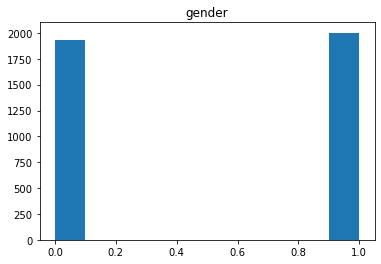

--------------------------------------------------------


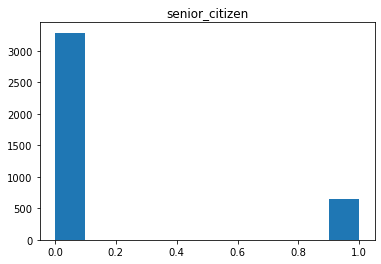

--------------------------------------------------------


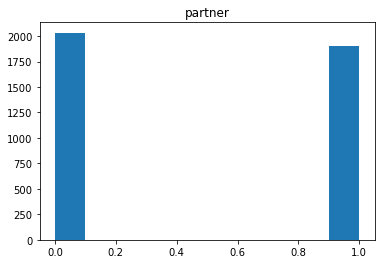

--------------------------------------------------------


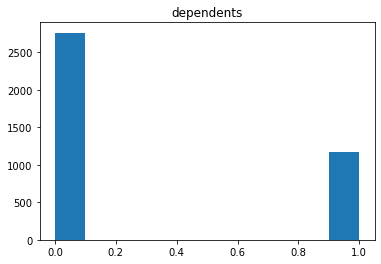

--------------------------------------------------------


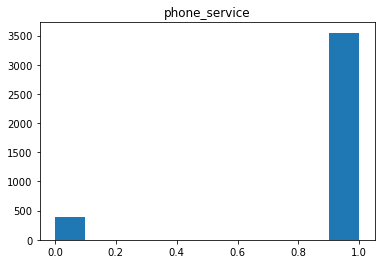

--------------------------------------------------------


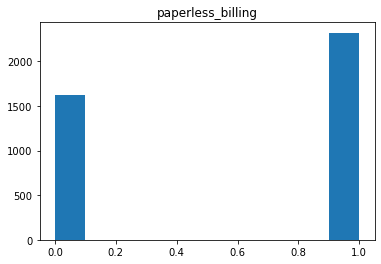

--------------------------------------------------------


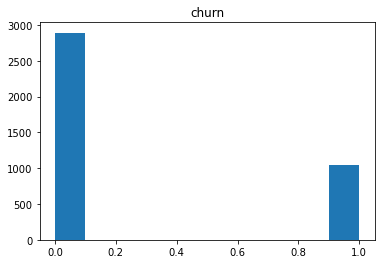

--------------------------------------------------------


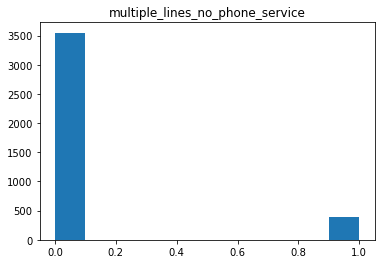

--------------------------------------------------------


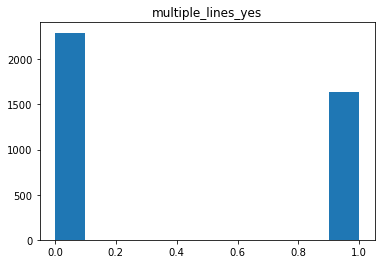

--------------------------------------------------------


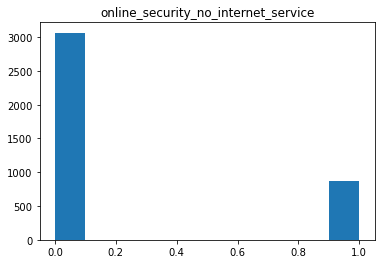

--------------------------------------------------------


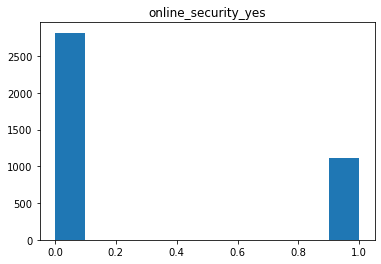

--------------------------------------------------------


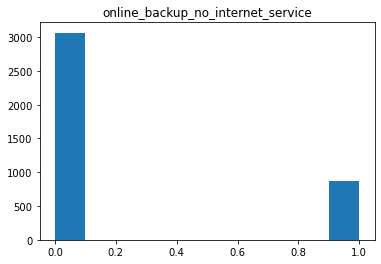

--------------------------------------------------------


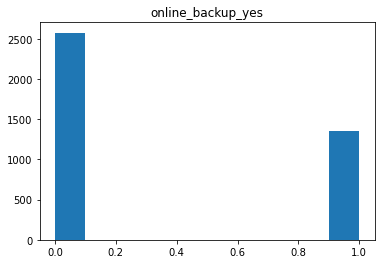

--------------------------------------------------------


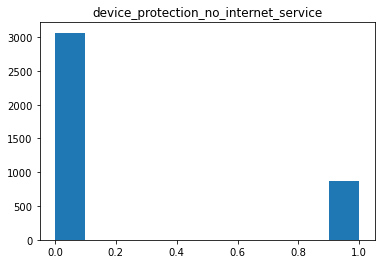

--------------------------------------------------------


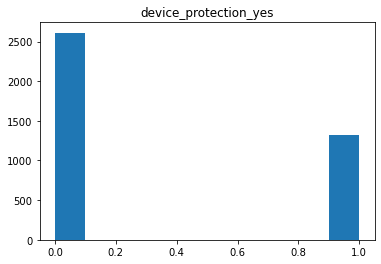

--------------------------------------------------------


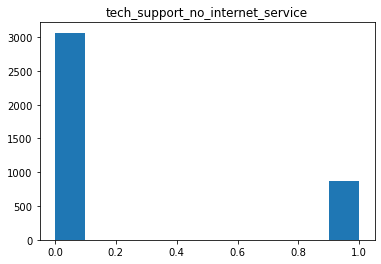

--------------------------------------------------------


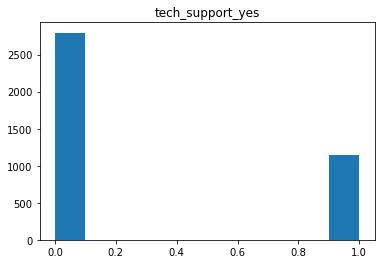

--------------------------------------------------------


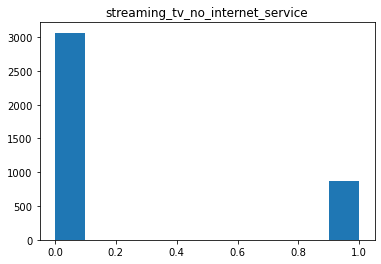

--------------------------------------------------------


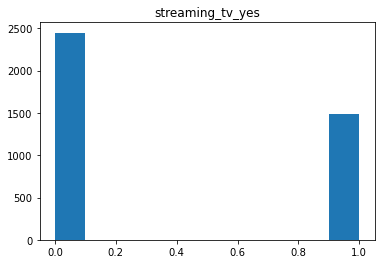

--------------------------------------------------------


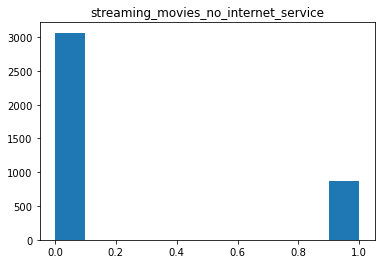

--------------------------------------------------------


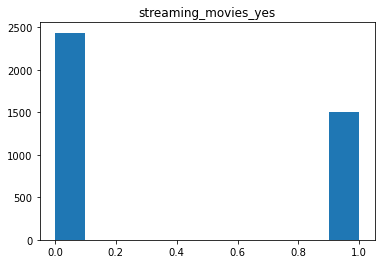

--------------------------------------------------------


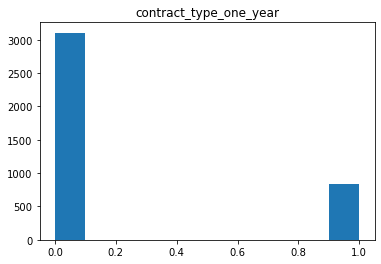

--------------------------------------------------------


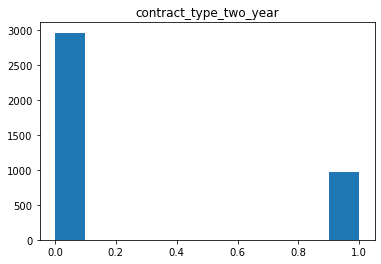

--------------------------------------------------------


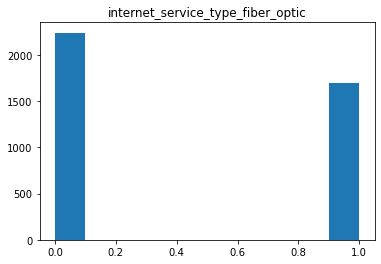

--------------------------------------------------------


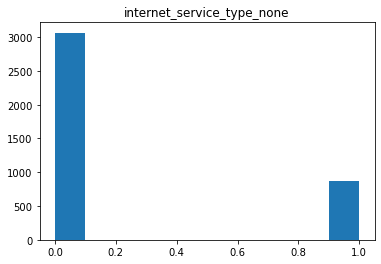

--------------------------------------------------------


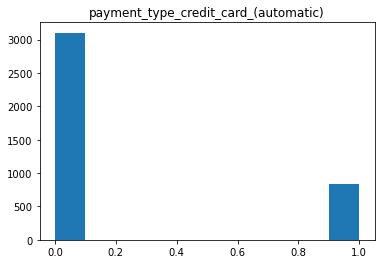

--------------------------------------------------------


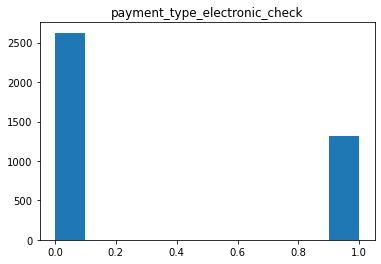

--------------------------------------------------------


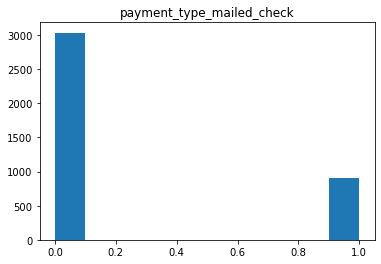

--------------------------------------------------------


In [19]:
for col in train[bin_cols]:
    plt.hist(train[col])
    plt.title(col)
    plt.show()
    print('--------------------------------------------------------')

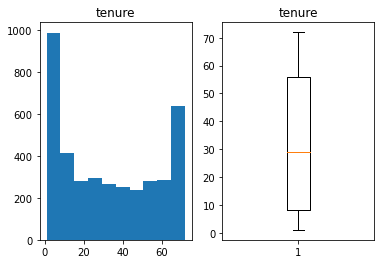

-------------------------------------------


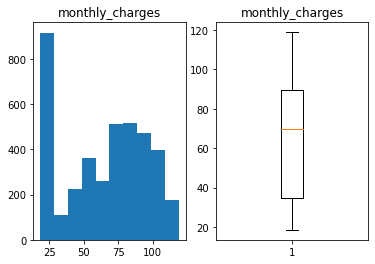

-------------------------------------------


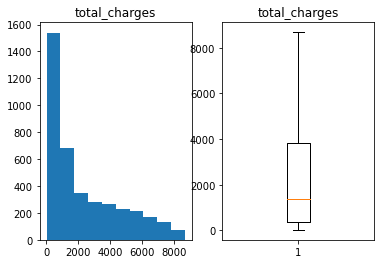

-------------------------------------------


In [20]:
for col in train.columns:
    values = train[col].nunique()
    if values > 2:
        plt.subplot(1, 2, 1)
        plt.hist(train[col])
        plt.title(col)
        
        plt.subplot(1, 2, 2)
        plt.boxplot(train[col])
        plt.title(col)
        plt.show()
        print('-------------------------------------------')


In [21]:
print(f'Overall churn rate: {train.churn.mean()}')

Overall churn rate: 0.2656845313690627


In [22]:
churn_df = train[train.churn == 1]

no_churn_df = train[train.churn == 0]

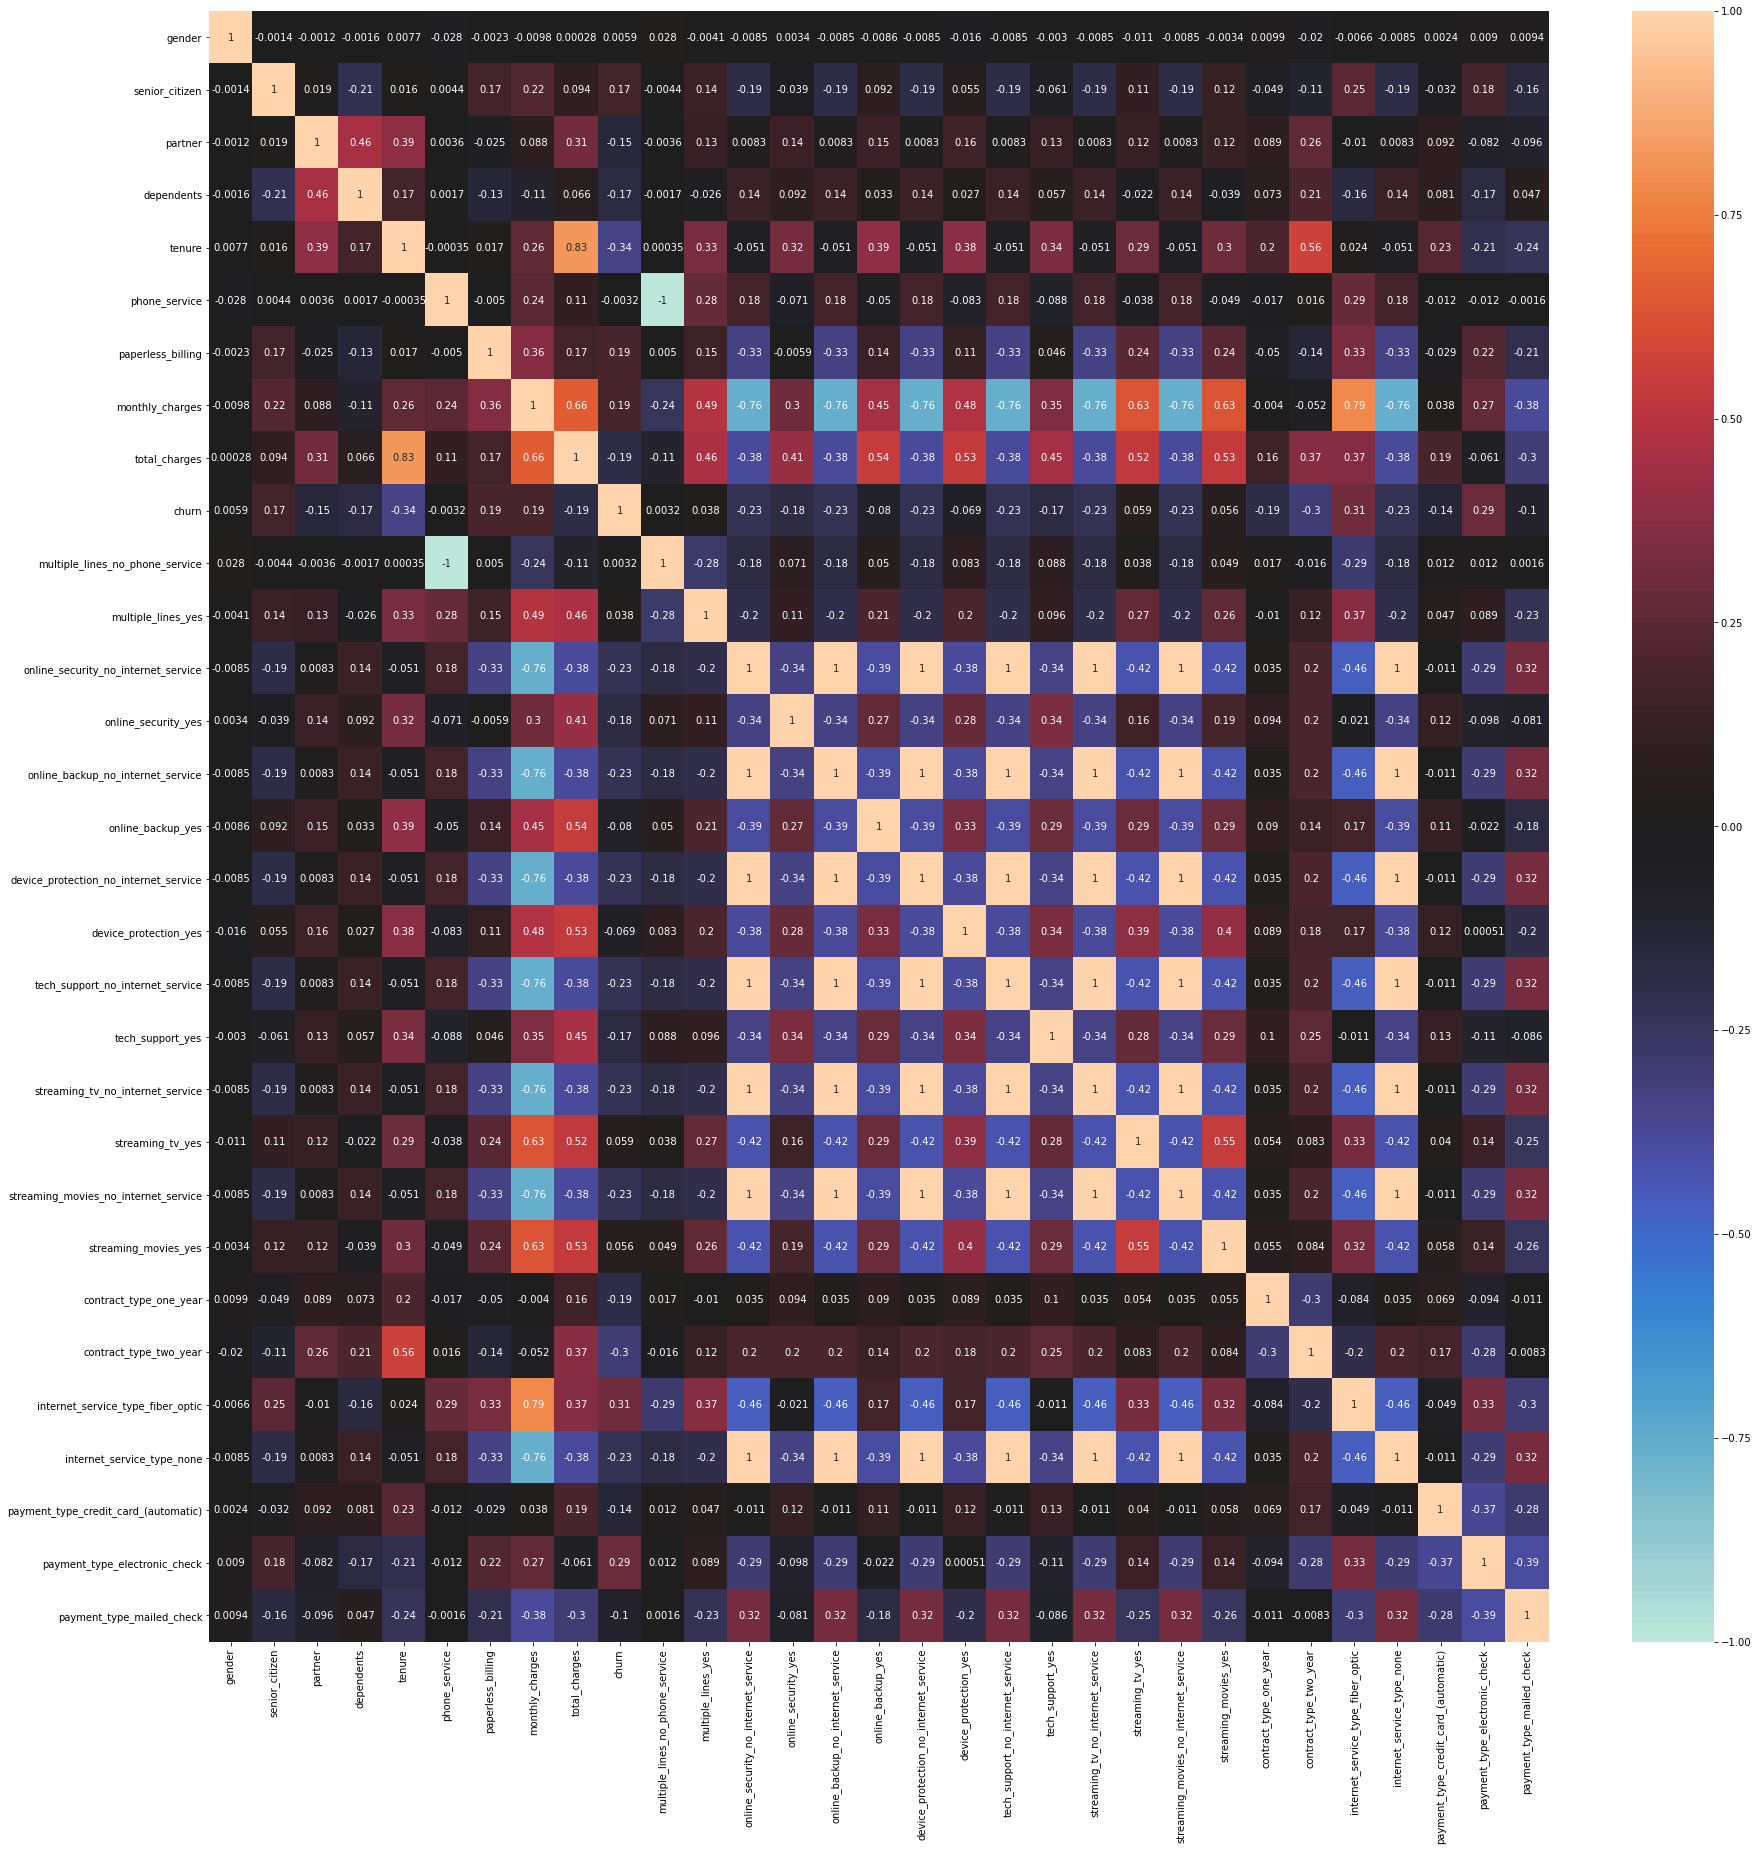

In [42]:
plt.rc('figure', figsize = (30, 30))
plt.rc('font', size = 10)

sns.heatmap(train.corr(), center = 0, annot = True)
plt.show()